In [1]:
import torch
import numpy as np
import pandas as pd

from train_model import run_model, MODELS, WordModel, train_model, test_model
from data_processor import DoqProcessor, VerbProcessor, ProstProcessor

from matplotlib import pyplot as plt

In [2]:
doq_train = DoqProcessor('train')
train_labels, _, train_sentences, _ = doq_train.forward()

doq_test = DoqProcessor('test')
test_labels, _, test_sentences, _ = doq_test.forward()

doq = {'name': 'doq'}
doq['train'] = {
    'labels': train_labels,
    'sents': train_sentences,
}

doq['test'] = {
    'labels': test_labels,
    'sents': test_sentences,
}

In [2]:
prost_train = ProstProcessor('train', batch_size=0, attribute='all')
train_labels, _, train_sentences, _ = prost_train.forward()

prost_test = ProstProcessor('test', batch_size=0, attribute='all')
test_labels, _, test_sentences, _ = prost_test.forward()

test_labels = np.array(test_labels)
test_sentences = np.array(test_sentences)

Using custom data configuration default
Reusing dataset prost (/Users/g/.cache/huggingface/datasets/corypaik___prost/default/1.0.1/5723fec956da2bd5e34a0ac6f53f398b771fbb743fc979c6a50b513888d537c7)
Loading cached split indices for dataset at /Users/g/.cache/huggingface/datasets/corypaik___prost/default/1.0.1/5723fec956da2bd5e34a0ac6f53f398b771fbb743fc979c6a50b513888d537c7/cache-3ba89f75d16d1d23.arrow and /Users/g/.cache/huggingface/datasets/corypaik___prost/default/1.0.1/5723fec956da2bd5e34a0ac6f53f398b771fbb743fc979c6a50b513888d537c7/cache-dea55751f6b71d2b.arrow
Using custom data configuration default
Reusing dataset prost (/Users/g/.cache/huggingface/datasets/corypaik___prost/default/1.0.1/5723fec956da2bd5e34a0ac6f53f398b771fbb743fc979c6a50b513888d537c7)
Loading cached split indices for dataset at /Users/g/.cache/huggingface/datasets/corypaik___prost/default/1.0.1/5723fec956da2bd5e34a0ac6f53f398b771fbb743fc979c6a50b513888d537c7/cache-556ac204ac069f7c.arrow and /Users/g/.cache/huggingf

In [3]:
overlap = np.array(set(train_sentences) & set(test_sentences))

indexs = []
for i, sent in enumerate(test_sentences):
    if sent not in overlap:
        indexs += [i]

indexs = np.array(indexs)

test_labels = list(test_labels[indexs])
test_sentences = list(test_sentences[indexs])

print(len(test_labels), len(test_sentences))

prost = {'name': 'prost'}
prost['train'] = {
    'labels': train_labels,
    'sents': train_sentences,
}

prost['test'] = {
    'labels': test_labels[-1000:],
    'sents': test_sentences[-1000:],
}

7496 7496


In [5]:
# verb = {}
# for attr in ['weight', 'speed', 'size', 'strength', 'rigidness']:
#     verb_train = VerbProcessor(attr, 20, 'train', 0)
#     train_labels, _, train_sentences, _ = verb_train.forward()

#     verb_test = VerbProcessor(attr, 20, 'test', 0)
#     test_labels, _, test_sentences, _ = verb_test.forward()

#     verb[attr] = {}
#     verb[attr]['train'] = {
#         'labels': train_labels,
#         'sents': train_sentences,
#     }

#     verb[attr]['test'] = {
#         'labels': test_labels,
#         'sents': test_sentences,
#     }

verb = {
    'name': 'verb',
    'train': {
        'sents': [],
        'labels': [],
    },
    'test': {
        'sents': [],
        'labels': [],
    }
}

for attr in ['weight', 'speed', 'size', 'strength', 'rigidness']:
    verb_train = VerbProcessor(attr, 20, 'train', 0)
    train_labels, _, train_sentences, _ = verb_train.forward()
    
    verb['train']['labels'] += train_labels
    verb['train']['sents'] += train_sentences

    verb_test = VerbProcessor(attr, 20, 'test', 0)
    test_labels, _, test_sentences, _ = verb_test.forward()
    
    verb['test']['labels'] += test_labels
    verb['test']['sents'] += test_sentences
    break

In [15]:
def evaluate_prost(model, try_encoder=True):    
    m = WordModel(model, try_encoder=try_encoder)
    train_features = m.get_features(prost['train']['sents'])
    test_features = m.get_features(prost['test']['sents'])
    
    print(train_features.shape, test_features.shape)
    
    
    lr = train_model(train_features, prost['train']['labels'])
    acc, probs, errors = test_model(lr, test_features, prost['test']['labels'], return_probs=True)
    
    assert len(probs) % 4 == 0
    
    correct_count = 0.0
    
    for i in range(0, probs.shape[0], 4):
        example = probs[i:i+4]
        true_pred = np.max(example, axis=0)
        
        for j, ex in enumerate(example):
            if ex[1] == true_pred[1] and prost['test']['labels'][i + j]:
                correct_count += 1
                break
    
    return correct_count / (probs.shape[0] / 4) * 100, errors, probs

In [10]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [19]:
model_preds = {}

In [20]:
model_accs = {model: {} for model in MODELS}

In [22]:
# Non-pooled evaluation
for model in MODELS:
    if model not in model_preds:
        model_preds[model] = {}
    
    m = WordModel(model, try_encoder=True)
    for d in [doq, verb, prost]:
        if d['name'] in model_preds[model]:
            continue

        print(model, d['name'])
        # train
        try:
            train_features = m.get_features(d['train']['sents'])
            lr = train_model(train_features, d['train']['labels'])

            test_features = m.get_features(d['test']['sents'])
            model_preds[model][d['name']] = [x[0] for x in np.array(lr.predict_proba(test_features))]
            accs, _ = test_model(lr, test_features, d['test']['labels'])
            model_accs[model][d['name']] = accs
        except Exception as e:
             print(e)

t5 doq
Model doesn't have native encoder support, use embeddings
t5 verb
Model doesn't have native encoder support, use embeddings
t5 prost
Model doesn't have native encoder support, use embeddings
lxmert doq
Model doesn't have native encoder support, use embeddings
lxmert verb
Model doesn't have native encoder support, use embeddings
lxmert prost
Model doesn't have native encoder support, use embeddings
uniter doq
forward() got an unexpected keyword argument 'input_ids'
uniter verb
forward() got an unexpected keyword argument 'input_ids'
uniter prost
forward() got an unexpected keyword argument 'input_ids'


In [6]:
d = prost
m = WordModel('roberta_small', try_encoder=False)
train_features = m.get_features(d['train']['sents'])
lr = train_model(train_features, d['train']['labels'])

test_features = m.get_features(d['test']['sents'])
probs = [x[0] for x in np.array(lr.predict_proba(test_features))]
acc1, _ = test_model(lr, test_features, d['test']['labels'])

In [7]:
m = WordModel('roberta', try_encoder=False)
train_features = m.get_features(d['train']['sents'])
lr2 = train_model(train_features, d['train']['labels'])

test_features = m.get_features(d['test']['sents'])
probs2 = [x[0] for x in np.array(lr.predict_proba(test_features))]
acc2, _ = test_model(lr, test_features, d['test']['labels'])


In [16]:
acc1, _, probs1 = evaluate_prost('roberta', try_encoder=False)

(2000, 76800) (1000, 76800)


In [17]:
acc2, _, probs2 = evaluate_prost('roberta_small', try_encoder=False)

(2000, 76800) (1000, 76800)


In [25]:
df = pd.DataFrame({'roberta': [x[0] for x in probs1], 'roberta_small': [x[0] for x in probs2]}.items())

In [38]:
1- scipy.spatial.distance.cosine([x[0] for x in probs1], [x[0] for x in probs2])

0.8531758476416049

In [93]:
verbose = {}
for model in model_preds:
    verbose[model] = []
    for d in model_preds[model]:
        if d == 'verb':
            verbose[model] += model_preds[model][d]

In [94]:
df = pd.DataFrame(verbose)
df = df[['roberta_small', 'roberta', 't5', 'clip', 'lxmert', 'visualbert', 'uniter']]

# import seaborn as sns

fig = plt.figure(figsize=(12, 10))

sns.heatmap(df.corr(), annot = True).set(title='Correlation of VERB probabilities using model embeddings')


In [12]:
df_errors_word = pd.DataFrame(model_errors)
df_accs_word = pd.DataFrame(model_accs)

In [14]:
df_errors_full = pd.DataFrame(model_errors)
df_accs_full = pd.DataFrame(model_accs)

df_accs_full.to_csv("./checkpoint_embed_accs.csv")
df_errors_full.to_csv("./checkpoint_embed_errors.csv")

In [49]:
df_accs_full = pd.DataFrame(model_accs)

In [279]:
df_t = df_accs_full.T
df_t['verb'] = (df_accs_full.T.verb_weight + df_accs_full.T.verb_size + df_accs_full.T.verb_strength + df_accs_full.T.verb_speed + df_accs_full.T.verb_rigidness) / 5



In [ ]:
df_t

NameError: name 'df_t' is not defined

In [ ]:
df_t.verb = pd.round

In [374]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Model

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

In [381]:
input_ids = tokenizer('translate English to German: I am not from germany', return_tensors='pt').input_ids
outputs = model.generate(input_ids)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Ich bin nicht aus Deutschland.


In [301]:
from tqdm import tqdm

In [290]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5Model.from_pretrained('t5-small')



input_ids = tokenizer("Studies have been shown that owning a dog is good for you", return_tensors="pt").input_ids  # Batch size 1
decoder_input_ids = tokenizer("Studies show that", return_tensors="pt").input_ids  # Batch size 1

outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
last_hidden_states = outputs.last_hidden_state

In [306]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5Model.from_pretrained('t5-small')

def get_features(input_sentences, pooled=False):
    all_features = []
    iters = len(input_sentences)

    for i in tqdm(range(iters)):
        input_ids = tokenizer(input_sentences[i], return_tensors="pt", padding='max_length', truncation=True, max_length=20).input_ids
        
        prompt = ""
        if '[SEP]' in input_sentences[i]:
            prompt = input_sentences[i].split('[SEP]')[0]
        else:
            prompt = input_sentences[i].split('than')[0]
        
        decoder_input_ids = tokenizer(prompt, return_tensors="pt", padding='max_length', truncation=True, max_length=20).input_ids  # Batch size 1
        outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
        all_features += [outputs.last_hidden_state.reshape(1, -1)]

    with torch.no_grad():
        out = torch.cat(all_features).cpu().numpy()

    return out

In [316]:
accs = []
for attr in ['weight', 'speed', 'size', 'rigidness', 'strength']:
    features = get_features(verb[attr]['train']['sents'])
    lr = train_model(features, verb[attr]['train']['labels'])

    test_features = get_features(verb[attr]['test']['sents'])
    acc, errors = test_model(lr, test_features, verb[attr]['test']['labels'])
    
    accs += [acc]

100%|█████████████████████████████████████████████████████████████████████████████████| 1180/1180 [01:29<00:00, 13.13it/s]


In [319]:
np.mean(accs)

74.7171526595102

In [311]:
features = get_features(prost['train']['sents'])
lr = train_model(features, prost['train']['labels'])

test_features = get_features(prost['test']['sents'])
acc, errors = test_model(lr, test_features, prost['test']['labels'])

100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.12it/s]


In [315]:
acc

87.5

In [88]:
print(prost['train']['sents'][13])

The ball dropped onto the carpet bounces the fewest times. [SEP] A person is trying to bounce a rubber ball. They drop a first ball onto rubber, a second ball onto carpet, a third ball onto steel, and a fourth ball onto concrete.


In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=120)

cov = np.cov(df_accs_full, bias=True)

sns.heatmap(cov, annot=True, fmt='g', xticklabels=df_accs_full.columns, yticklabels=df_accs_full.columns)

NameError: name 'df_accs_full' is not defined

<Figure size 960x720 with 0 Axes>

In [176]:
emodel = df_errors_full.T
emodel

,doq,prost,verb_weight,verb_speed,verb_size,verb_strength,verb_rigidness
clip,"[1, 9, 10, 11, 12, 14, 17, 18, 19, 20, 22, 23,...","[1, 7, 8, 12, 13, 19, 27, 28, 29, 30, 31, 32, ...","[0, 2, 7, 10, 17, 18, 26, 32, 36, 39, 58, 64, ...","[0, 2, 7, 11, 12, 13, 18, 26, 28, 31, 37, 43, ...","[0, 5, 7, 18, 19, 29, 33, 44, 50, 53, 55, 58, ...","[6, 15, 16, 24, 26, 28, 31, 36, 37, 39, 45, 52...","[0, 1, 5, 8, 13, 14, 17, 21, 22, 23, 26, 32, 3..."
roberta,"[1, 7, 10, 11, 12, 17, 19, 20, 24, 26, 35, 38,...","[3, 7, 8, 15, 18, 19, 20, 31, 32, 37, 40, 47, ...","[0, 7, 10, 16, 17, 18, 20, 26, 32, 36, 38, 39,...","[4, 7, 11, 12, 18, 26, 30, 31, 37, 45, 47, 50,...","[0, 2, 5, 7, 18, 19, 29, 33, 44, 50, 53, 58, 5...","[0, 4, 6, 14, 16, 24, 26, 28, 31, 35, 36, 39, ...","[1, 5, 8, 13, 14, 21, 22, 23, 26, 28, 32, 34, ..."
roberta_small,"[1, 6, 10, 11, 12, 14, 16, 20, 22, 24, 25, 26,...","[7, 18, 19, 20, 29, 30, 32, 55, 57, 63, 67, 69...","[0, 2, 5, 7, 8, 16, 17, 18, 23, 26, 29, 32, 36...","[0, 2, 4, 7, 8, 11, 13, 16, 18, 19, 26, 30, 31...","[1, 2, 5, 7, 8, 17, 18, 19, 29, 33, 34, 39, 44...","[2, 4, 6, 7, 16, 24, 26, 28, 31, 35, 36, 37, 4...","[0, 1, 2, 4, 5, 6, 7, 8, 14, 16, 18, 19, 21, 2..."
visualbert,"[7, 8, 10, 12, 19, 20, 24, 28, 31, 32, 33, 34,...","[3, 7, 8, 10, 12, 13, 15, 19, 20, 27, 30, 31, ...","[0, 7, 10, 16, 17, 18, 20, 26, 32, 36, 37, 38,...","[0, 1, 4, 7, 8, 11, 12, 13, 18, 26, 28, 31, 37...","[0, 1, 2, 5, 7, 18, 19, 29, 33, 34, 39, 44, 45...","[6, 15, 16, 24, 26, 28, 31, 35, 39, 45, 47, 52...","[0, 1, 5, 8, 14, 17, 21, 23, 26, 28, 32, 33, 3..."
t5,"[1, 2, 3, 5, 8, 10, 11, 12, 14, 17, 19, 20, 23...","[3, 5, 6, 7, 8, 12, 13, 15, 19, 27, 29, 30, 31...","[0, 7, 10, 18, 26, 29, 32, 36, 39, 58, 61, 64,...","[1, 4, 7, 12, 13, 26, 28, 30, 31, 37, 40, 47, ...","[0, 1, 5, 7, 19, 29, 33, 44, 50, 53, 55, 58, 6...","[4, 6, 8, 16, 24, 26, 28, 31, 35, 39, 47, 52, ...","[0, 1, 5, 8, 9, 14, 21, 22, 23, 26, 28, 30, 32..."
lxmert,"[0, 1, 4, 7, 8, 9, 10, 11, 12, 14, 19, 20, 22,...","[3, 7, 8, 15, 18, 20, 31, 32, 37, 40, 47, 49, ...","[0, 7, 10, 17, 18, 26, 29, 32, 36, 38, 49, 58,...","[0, 1, 7, 11, 12, 13, 26, 28, 30, 31, 37, 43, ...","[0, 5, 7, 18, 29, 34, 35, 38, 39, 44, 50, 53, ...","[4, 6, 8, 15, 16, 24, 26, 28, 31, 36, 39, 45, ...","[0, 1, 8, 9, 13, 14, 17, 21, 23, 26, 28, 32, 3..."
uniter,"[1, 8, 9, 10, 12, 14, 20, 24, 28, 37, 38, 39, ...","[3, 7, 8, 15, 19, 27, 31, 32, 37, 42, 47, 50, ...","[0, 2, 7, 10, 17, 26, 29, 32, 36, 37, 39, 49, ...","[0, 4, 6, 7, 11, 12, 13, 18, 26, 28, 30, 31, 3...","[0, 1, 7, 8, 18, 29, 34, 38, 50, 55, 58, 66, 7...","[1, 2, 5, 6, 15, 16, 24, 26, 28, 31, 36, 37, 3...","[0, 1, 5, 8, 9, 10, 13, 17, 18, 21, 23, 26, 28..."


In [242]:
# Verb Weight is connonical, all models (excluding rob_small) are within 7% accuracy
# However, we see significant differences in which questions the text models miss and which the mmm miss

mmm_weight = set(emodel.T.visualbert.verb_weight) & set(emodel.T.lxmert.verb_weight) & set(emodel.T.uniter.verb_weight) & set(emodel.T['clip'].verb_weight)
print(f"All 4 mmm miss {len(mmm_weight)}:\n{mmm_weight}\n")

rob_weight = set(emodel.T.roberta.verb_weight)
print(f"How many of these does roberta miss?\n{len(rob_weight & mmm_weight)}")

print(f"\nThe following are the 10 sentences that NO mmm get, but roberta does:") 
for i in mmm_weight - rob_weight:
    print(get_q(i, verb['weight']['test']))

print(f"\nHere are the {len(rob_weight - set(emodel.T.visualbert.verb_weight))} questions that VisualBert got correct, but roberta didn't:")
for i in rob_weight - set(emodel.T.visualbert.verb_weight):
    print(get_q(i, verb['weight']['test']))
    
print(f"\nHere are the {len(rob_weight - set(emodel.T['clip'].verb_weight))} questions that CLIP got correct, but roberta didn't:")
for i in rob_weight - set(emodel.T['clip'].verb_weight):
    print(get_q(i, verb['weight']['test']))
    
print(f"\nHere are the {len(rob_weight - set(emodel.T.uniter.verb_weight))} questions that UNITER got correct, but roberta didn't:")
for i in rob_weight - set(emodel.T.uniter.verb_weight):
    print(get_q(i, verb['weight']['test']))

All 4 mmm miss 138:
{0, 7, 10, 527, 17, 26, 1051, 1055, 32, 1056, 36, 553, 1068, 1070, 559, 562, 563, 58, 1083, 572, 64, 1090, 1096, 592, 90, 91, 603, 93, 605, 607, 1118, 612, 106, 618, 110, 622, 1141, 633, 1149, 127, 1156, 645, 649, 142, 1167, 1176, 156, 1181, 670, 162, 163, 675, 165, 167, 1197, 687, 178, 181, 694, 184, 1208, 699, 1216, 194, 710, 205, 1236, 725, 730, 1244, 734, 1248, 1255, 237, 1273, 1279, 1280, 1284, 778, 267, 788, 790, 279, 281, 283, 285, 801, 292, 297, 821, 315, 321, 322, 324, 840, 845, 846, 344, 862, 352, 358, 361, 365, 877, 367, 887, 376, 889, 380, 896, 386, 387, 390, 902, 398, 408, 932, 425, 427, 939, 429, 956, 958, 452, 454, 465, 466, 980, 469, 475, 990, 479, 992, 1006, 496, 501, 1016, 509}

How many of these does roberta miss?
128

The following are the 10 sentences that NO mmm get, but roberta does:
(801, 'A scissors is heavier than a hand', False)
(1096, 'A shoulder is heavier than a door', False)
(939, 'A messenger is heavier than a king', 'Ambigious')
(398

In [252]:
# Verb verb_speed is the hardest
# However, we see significant differences in which questions the text models miss and which the mmm miss

mmm_speed = set(emodel.T.visualbert.verb_speed) & set(emodel.T.lxmert.verb_speed) & set(emodel.T.uniter.verb_speed) & set(emodel.T['clip'].verb_speed)
print(f"All 4 mmm miss {len(mmm_speed)}:\n{mmm_speed}\n")

rob_speed = set(emodel.T.roberta.verb_speed)
print(f"How many of these does roberta miss?\n{len(rob_speed & mmm_speed)}")

print(f"\nThe following are the {len(mmm_speed - rob_speed)} sentences that NO mmm get, but roberta does:") 
for i in mmm_speed - rob_speed:
    print(get_q(i, verb['speed']['test']))

print(f"\nHere are the {len(rob_speed - set(emodel.T.visualbert.verb_speed))} questions that VisualBert got correct, but roberta didn't:")
for i in rob_speed - set(emodel.T.visualbert.verb_speed):
    print(get_q(i, verb['speed']['test']))
    
print(f"\nHere are the {len(rob_speed - set(emodel.T['clip'].verb_speed))} questions that CLIP got correct, but roberta didn't:")
print(f"Number of clip errors: {len(emodel.T['clip'].verb_speed)}, number of roberta errors: {len(rob_speed)}")
for i in rob_speed - set(emodel.T['clip'].verb_speed):
    print(get_q(i, verb['speed']['test']))
    
print(f"\nHere are the {len(rob_speed - set(emodel.T.uniter.verb_speed))} questions that UNITER got correct, but roberta didn't:")
for i in rob_speed - set(emodel.T.uniter.verb_speed):
    print(get_q(i, verb['speed']['test']))

All 4 mmm miss 222:
{0, 515, 1027, 517, 518, 7, 520, 1028, 11, 12, 13, 524, 525, 526, 1038, 1040, 533, 1048, 26, 539, 28, 1053, 31, 37, 549, 1063, 552, 43, 1067, 557, 1068, 47, 561, 565, 54, 58, 59, 571, 573, 1083, 1085, 1086, 1090, 1091, 584, 73, 591, 80, 81, 593, 83, 84, 594, 596, 600, 90, 607, 609, 611, 612, 616, 619, 620, 109, 624, 625, 114, 626, 628, 631, 122, 636, 128, 132, 646, 649, 143, 144, 145, 147, 151, 663, 153, 665, 669, 164, 685, 175, 688, 177, 692, 696, 190, 702, 192, 194, 707, 199, 716, 720, 212, 726, 217, 730, 221, 736, 226, 740, 741, 231, 743, 233, 745, 747, 236, 748, 751, 247, 760, 762, 253, 766, 259, 776, 265, 780, 785, 274, 786, 277, 278, 280, 282, 795, 800, 289, 290, 293, 295, 297, 298, 809, 308, 309, 820, 311, 824, 825, 314, 323, 836, 326, 838, 329, 333, 850, 851, 340, 853, 854, 855, 858, 348, 350, 864, 354, 355, 877, 883, 373, 374, 376, 889, 383, 384, 899, 905, 395, 907, 404, 916, 407, 411, 413, 926, 416, 418, 935, 936, 938, 436, 950, 439, 446, 960, 452, 458, 45

In [254]:
doq['train']['sents'][4]

'A watermelon is heavier than a wasabi'

In [150]:
common_doq_errors = set(range(10000))

for model, errors in zip(emodel.index, emodel.doq):
    common_doq_errors = common_doq_errors & set(errors)

out = []
for e in common_doq_errors:
    out += [get_q(e, prost[''])]

common_misses = pd.DataFrame(out)
common_misses.to_csv('./common_misses.csv')

# Of the 92 questions all get wrong, many are understandable. Human baseline (panel of 3): only get around 50% right. Dataset Errors
human_baseline_misses = human_baseline.inedx[human_baseline.Correct == False].values
human_baseline_makes = human_baseline.inedx[human_baseline.Correct == True].values

# The indexs of sentences that ALL models missed, but we would expect them to guess correctly
human_baseline_makes

# Of the 92 questions all get wrong, only 12 body part
body_part_misses = [10, 556, 59, 63, 113, 673, 676, 191, 752, 284, 319, 476]

# Of the 12 body part misses, human baseline only got 5 right --> very difficult questions

In [142]:
human_baseline = pd.read_csv('common_misses_human.csv', header=1)

In [158]:
for i in human_baseline_makes:
    if i not in body_part_misses:
        continue
    print(get_q(i, doq['test']['sents']))

(10, 'A vagina is bigger than a throat', False)
(556, 'A tongue is bigger than a neck', False)
(676, 'A muscle is bigger than a tract', True)
(284, 'A nose is bigger than a arse', False)
(319, 'A abdomen is bigger than a tummy', False)


In [175]:
b = []
for x in body_part_misses:
    b += get_q(x)[1].split(' ')

set(b)

{'A',
 'a',
 'abdomen',
 'arse',
 'artery',
 'bigger',
 'brain',
 'breast',
 'ear',
 'foot',
 'head',
 'is',
 'muscle',
 'neck',
 'nerve',
 'nose',
 'rectum',
 'scalp',
 'skull',
 'than',
 'throat',
 'tongue',
 'tract',
 'tummy',
 'vagina'}

In [63]:
# 92 questions ALL models get wrong
idx = np.array(list(common_doq_errors))

labels = [bool(x == 1) for x in np.array(doq['test']['labels'])[idx]]
labels.count(False), labels.count(True)

(65, 27)

In [77]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(doq['test']['sents'])

true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 faster
 lunging
 sprinting
 throwing
 running
 rocket
 toy
 stomping
 pushing
 turning
Cluster 1:
 heavier
 ssd
 sugarcane
 parsnip
 bean
 receiver
 jatropha
 celery
 lemon
 leek
Cluster 2:
 bigger
 arm
 pavilion
 nose
 foot
 groin
 retina
 ear
 eyeball
 skull


/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top terms per cluster:
Cluster 0:
 bigger
 arm
 pavilion
 nose
 foot
 groin
 retina
 ear
 eyeball
 skull
Cluster 1:
 heavier
 ssd
 sugarcane
 bean
 receiver
 celery
 parsnip
 lemon
 leek
 endive
Cluster 2:
 whizzing
 rolling
 faster
 driving
 slithering
 moping
 traversing
 marching
 waddling
 meandering
Cluster 3:
 parsley
 jicama
 heavier
 fennel
 tarragon
 lavender
 canola
 sesame
 orange
 jatropha
Cluster 4:
 faster
 lunging
 throwing
 running
 rocket
 toy
 pushing
 turning
 sprinting
 pigeon


/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


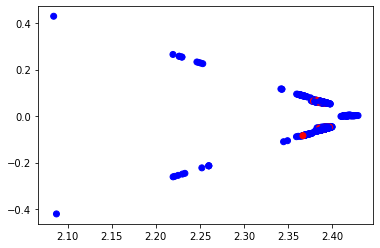

In [127]:
vectorizer = TfidfVectorizer(stop_words='english')

# sents = [x for x in np.array(doq['test']['sents'])[idx]]

X = vectorizer.fit_transform(doq['test']['sents'])

true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
out = model.fit_transform(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print
    
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=2)
out = pca.fit_transform(out)

all_idx = np.array(list(range(len(doq['test']['sents']))))

x, y = zip(*out)

cmap1 = []
for i in all_idx:
    if i in idx:
        cmap1 += ['red']
    else:
        cmap1 += ['blue']

plt.scatter(x, y, c=cmap1)

In [122]:
# The only Model to get example 1 correct was VisualBert. Why? 

doq['test']['sents'][1], bool(doq['test']['labels'][1] == 1)

# Requires specific knowledge!


('A moose is heavier than a poodle', True)

In [39]:
# Every model gets example 10 wrong, why? 

doq['test']['sents'][10], bool(doq['test']['labels'][10] == 1)

# Could this higlight the outsized importance of sexual organs? "Percieved larger?" 
# Very few photos of vaginas in dataset presumably



('A vagina is bigger than a throat', False)

In [241]:
def get_q(num, data):
    label = {'-1': False, '0': 'Ambigious', '1': True}
    return(num, data['sents'][num], label[str(int(data['labels'][num]))])

In [46]:
# Only Uniter and VisualBert get question 11 correct, why?
get_q(11)

# A comparison of throwing vs. crawling --> many photos of babies crawling, people throwing
# People actions are in photos

# Q12 every model gets wrong
get_q(12)

# about buildings, not actions people do.


A throwing is faster than a crawling True
A pizzeria is bigger than a studio False


In [47]:
# Interestingly, all models get question 13 correct
get_q(13)


A shop is bigger than a plaza False


In [49]:
# Visualbert and Roberta Large only models to get question 14 correct

get_q(14)

# pretty ambigious 

A sanctuary is bigger than a cafeteria True


In [259]:
prost_lens = [len(x.split()) for x in prost['test']['sents']]
doq_lens = [len(x.split()) for x in doq['test']['sents']]
verb_lens = [len(x.split()) for x in verb['weight']['test']['sents']]

print(np.mean(prost_lens), np.mean(doq_lens), np.mean(verb_lens))

37.652 7.0 7.0


In [21]:
pf = df.mean(axis=1)

In [33]:
multimodal = df.clip + df.visualbert

TypeError: unsupported operand type(s) for +: 'method' and 'float'

In [50]:
pf = pf.T

In [54]:
multimodal = (pf['clip'] + pf['visualbert'])/2
unimodal = (pf['roberta'] + pf['roberta_small'])/2

In [69]:
models = pd.concat([multimodal, unimodal], axis=1)
models.columns =['visual+language', 'language']
models.T

,doq,prost,verb_weight,verb_speed,verb_size,verb_strength,verb_rigidness
visual+language,64.772727,33.057631,79.674166,73.357664,81.541502,76.483051,71.070518
language,61.772727,65.955176,77.928627,68.750000,77.588933,73.771186,67.926933


In [4]:
def evaluate_prost(model):
    m = WordModel(model, try_encoder=True)
    train_features = m.get_features(prost['train']['sents'])
    test_features = m.get_features(prost['test']['sents'])
    
    lr = train_model(train_features, prost['train']['labels'])
    acc, probs = test_model(lr, test_features, prost['test']['labels'], return_probs=True)
    
    assert len(probs) % 4 == 0
    
    correct_count = 0.0
    
    for i in range(0, probs.shape[0], 4):
        example = probs[i:i+4]
        true_pred = np.max(example, axis=0)
        
        for j, ex in enumerate(example):
            if ex[1] == true_pred[1] and prost['test']['labels'][i + j]:
                correct_count += 1
                break
    
    return correct_count / (probs.shape[0] / 4) * 100

In [36]:
accs_embed = {}

# Non-pooled evaluation
for model in MODELS:
    doq_acc = None
    prost_acc = None
    try:
        doq_acc = run_model(model, doq['train']['labels'], doq['train']['sents'], doq['test']['labels'], doq['test']['sents'], try_encoder=False, verbose=False)
        print("doq", doq_acc)
        verb_acc = {}
        for attr in verb:
            verb_acc[attr] = run_model(model, verb[attr]['train']['labels'], verb[attr]['train']['sents'], verb[attr]['test']['labels'], verb[attr]['test']['sents'], try_encoder=False, verbose=False)
            print(f"verb-{attr}", verb_acc[attr])
        prost_acc = evaluate_prost(model)
        print("prost", prost_acc)
    except Exception as e:
        print(e)
    
    accs_embed[model] = {
        'doq': doq_acc,
        'prost': prost_acc,
    }
    
    for attr in verb:
        accs_embed[model][f'verb_{attr}'] = verb_acc[attr]

100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 51.48it/s]

Expected 2D array, got 1D array instead:
array=[-2.6959957e-11 -4.3043177e-11  2.5684849e-12 ... -1.0659615e-02
 -2.2763608e-02 -1.0907674e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


NameError: name 'verb' is not defined

In [28]:
accs_df = accs_df.T

In [17]:
multimodal = (accs_df['clip'] + accs_df['lxmert'] + accs_df['visualbert'])/3
unimodal = (accs_df['roberta'] + accs_df['t5'] + accs_df['roberta_small'])/3

In [18]:
models = pd.concat([multimodal, unimodal], axis=1)
models.columns =['visual+language', 'language']
models.T

,doq,prost,verb_weight,verb_speed,verb_size,verb_strength,verb_rigidness
visual+language,63.484848,34.009249,81.872252,71.472019,82.29249,77.966102,71.651090
language,62.606061,49.501957,78.019136,68.248175,78.26087,73.389831,68.677428


In [24]:
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [20]:
m = WordModel('roberta', try_encoder=True)

train_features = m.get_features(prost['train']['sents'])
test_features = m.get_features(prost['test']['sents'])

100%|███████████████████████████████████████████| 50/50 [00:36<00:00,  1.36it/s]


In [337]:
m = WordModel('uniter', try_encoder=False)

batch = prost['train']['sents'][:30]
tokens = m.tokenizer(batch, return_tensors="pt", padding='max_length', truncation=True, max_length=70)

print(tokens.input_ids[0])
# train_features = m.get_features(prost['train']['sents'])
# test_features = m.get_features(prost['test']['sents'])

tensor([  101,  1109,  2473,  2262,  1114,  2949,  1110,  1103, 20773,  1111,
         1103,  5003,  1106,  7253,  1506,   119,   102,   138,  1825,  1110,
         7989,  1300, 15453,  1506,  1300,  1662,  9902,   119,  1109,  1148,
         2473,  1110,  2262,  1114,  2949,   117,  1103,  1248,  2473,  1110,
         2262,  1114, 11898,   117,  1103,  1503,  2473,  1110,  2262,  1114,
         2854,   117,  1105,  1103,  2223,  2473,  1110,  2262,  1114,  8439,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0])


In [21]:
train_features.shape

(2000, 15360)

In [22]:
test_features.shape

(1000, 15360)

In [25]:
lr = make_pipeline(StandardScaler(), SGDClassifier(random_state=0, max_iter=1000, loss="log", n_jobs=-1))

with torch.no_grad():
    lr.fit(train_features, prost['train']['labels'])

In [27]:
acc, probs = test_model(lr, test_features, prost['test']['labels'], return_probs=True, verbose=False)

In [30]:
l = []
for i, s in enumerate(prost['test']['sents']):
    if i % 4 == 0:
        l += [s]

for ex, prob in zip(l, probs):
    print(prob, ex)

[1. 0.] The circle around the car takes the least amount of paint. [SEP] A person paints a circle around a car, a house, a book, and a table.
[1. 0.] The lamps are the easiest to stack. [SEP] A person is trying to stack lamps, bottles, boxes, and eggs.
[0. 1.] The mirror is the hardest to roll. [SEP] A person is trying to roll a mirror, a bottle, a ball, and a can.
[1. 0.] The puck hit by the microwave slides the shortest distance. [SEP] A microwave, a brick, a leaf, and an egg moving at identical speeds each collide with a static hockey puck.
[1. 0.] The side of the seesaw with the coin moves up. [SEP] A coin and a brick are placed in baskets on either end of a perfectly balanced seesaw.
[1.00000000e+000 1.49446914e-161] The staircase leading to the top of the book is the easiest to walk up. [SEP] There are four staircases. The first leads to the top of a book, the second leads to the top of a mountain, the third leads to the top of a table, and the fourth leads to the top of a microw

In [19]:
evaluate_prost('roberta')

100%|███████████████████████████████████████████| 50/50 [00:35<00:00,  1.41it/s]


91.2